In [1]:
import numpy as np 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from funcs.auroralring import AuroralRing
from funcs.fitting import setup_model_sampler

namemap = {"imag" : [r"$i_{\rm mag}$", lambda x: x*180/np.pi, "deg"],
           "phimin" : [r"$\phi_{\rm min}$", lambda x: x*180/np.pi, "deg"],
           "phimax" : [r"$\phi_{\rm max}$", lambda x: x*180/np.pi, "deg"],
           "alpha_0" : [r"$\alpha$", lambda x: x/2/np.pi, ""],
           "dphi" : [r"width", lambda x: x*180/np.pi, "deg"],
           "ampl" : [r"rel. ampl.", lambda x: x, ""],
           "broaden" : [r"broadening", lambda x: x, "km/s"],
           "lat1": [r"$\theta_1$", lambda x: x*180/np.pi, "deg"],
           "lat2": [r"$\theta_2$", lambda x: x*180/np.pi, "deg"],
           "lon1": [r"$\phi_1$", lambda x: x*180/np.pi, "deg"],
           "lon2": [r"$\phi_2$", lambda x: x*180/np.pi, "deg"],
           "width1": [r"$r$", lambda x: x*180/np.pi, "deg"],}

In [2]:
# get all npy files from results/
files = glob.glob('results/*.npy')
files

['results/res_minspec_full_spot_True.npy',
 'results/res_medspec_full_spot_True.npy',
 'results/res_medspec_sub_ring_True.npy',
 'results/res_minspec_full_ring_True.npy',
 'results/res_minspec_full_spot_False.npy',
 'results/res_minspec_sub_ring_True.npy',
 'results/res_medspec_sub_spot_False.npy',
 'results/res_medspec_sub_spot_True.npy',
 'results/res_minspec_sub_spot_False.npy',
 'results/res_minspec_sub_spot_True.npy',
 'results/res_medspec_full_ring_True.npy']

In [3]:
# get npy files
# get the first file
file = files[-11]
# load the file
data = np.load(file, allow_pickle=True).item()
ws = data["weighted_samples"]
ws

{'upoints': array([[0.21479621, 0.16302943, 0.94398303, 0.97356172, 0.95348894],
        [0.07333765, 0.82795276, 0.68888138, 0.98024787, 0.20087818],
        [0.07675546, 0.15045858, 0.74158082, 0.95750781, 0.60072868],
        ...,
        [0.38100044, 0.35643016, 0.64935172, 0.35585463, 0.67579493],
        [0.38330879, 0.35688366, 0.65088486, 0.3564756 , 0.66640909],
        [0.38022347, 0.3562846 , 0.64751636, 0.35697421, 0.6696818 ]]),
 'points': array([[ 0.33740109,  1.02434409,  2.96561015,  2.92068515, 29.0697788 ],
        [ 0.11519852,  5.20218063,  2.16418469,  2.94074361, 14.01756363],
        [ 0.12056719,  0.94535916,  2.32974485,  2.87252342, 22.01457351],
        ...,
        [ 0.5984741 ,  2.23951676,  2.03999861,  1.06756388, 23.51589859],
        [ 0.60210004,  2.24236615,  2.0448151 ,  1.0694268 , 23.32818179],
        [ 0.59725363,  2.23860219,  2.03423265,  1.07092264, 23.39363598]]),
 'weights': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       

Text(0.5, 0, 'Iteration')

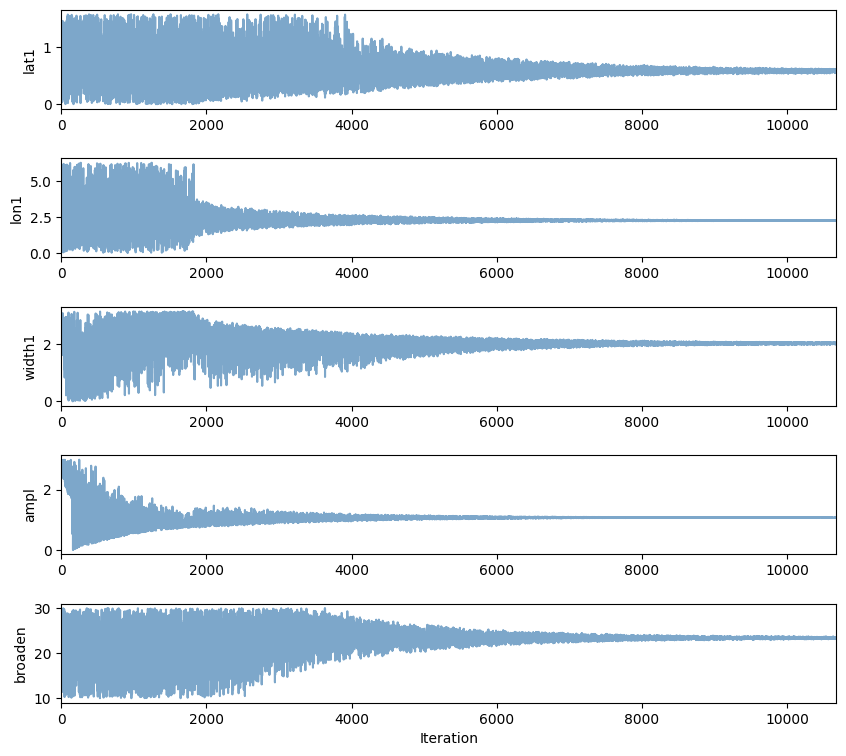

In [4]:
points = ws["points"]

fig, axes = plt.subplots(points.shape[1],1 , figsize=(10, 9))
for i in range(points.shape[1]):
    axes[i].plot(points[:,i], c="steelblue", alpha=0.7)
    nam = data["paramnames"][i]
    axes[i].set_ylabel(f"{nam}")
    axes[i].set_xlim(0, data["niter"])
# make space between subplots
plt.subplots_adjust(hspace=0.5)
axes[-1].set_xlabel("Iteration")

In [5]:
med, errlo, errup = data["posterior"]["median"], data["posterior"]["errlo"], data["posterior"]["errup"]


In [6]:
# extract model settings from the file name
listpars = file.split("_")
spec, full_sub, spotring, foreshortening = listpars[1], listpars[2], listpars[3], listpars[4][:-4]
spotring

'spot'

In [7]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 90 * np.pi/180

# rotation period in days
P_rot = 2.845 / 24.

# stellar radius in solar radii
R_star = R_star = (1.07 * u.R_jup).to(u.R_sun).value


In [8]:

omega = 2 * np.pi / P_rot

v_bins = np.linspace(-129, 129, 100)
v_mids = (v_bins[1:] + v_bins[:-1]) / 2

# maximum rot velocity of the star in km/s
vmax = omega * R_star * 695700. / 86400. # km/s

phi = np.linspace(0, 2*np.pi, 1000)





In [9]:


description = (f"median or minimum spectra?: {spec}\nfull or quiescence subtracted?"
               f": {full_sub}\nforeshortening: {foreshortening}\nmodel: {spotring}")


# data
df = pd.read_csv(f'data/lsr_norm_spectra_{spec}.csv', index_col=0, header=[0,1])

# select only index values between 6559 and 6566 
df = df.loc[(df.index > 6559.5) & (df.index < 6566)]

# lambda value convert to velocity
x = df.index.values
diffx = np.diff(x)
vbins = np.linspace(x[0]-diffx[0]/2, x[-1]+diffx[-1]/2, len(x)+1)
vbins = ((vbins - 6562.8) / 6562.8 * c).to(u.km/u.s).value
vmids = (vbins[1:] + vbins[:-1]) / 2

# for each column in df, select the median subcolumn
ys_ = []
ystds = []

# get the median and std values for each column 
for col in df.columns.levels[0]:
    for subcol in df.columns.levels[1]:
        if subcol == "median":
            ys_.append(df[col, subcol].values)
        elif subcol == "std":
            ystds.append(df[col, subcol].values)

# invert the order of ys and ystds
ys_ = ys_[::-1]
ystds = ystds[::-1]

# convert to numpy arrays (and take square of the stds to get variance)
ys_ = np.array(ys_)
yerr2 = np.array(ystds).astype(float)**2
sigma = np.mean(ystds)**2

# define how many subspectra we have and generate the rotational phase array
N = 10
subspecs = 3
alpha_edges = np.linspace(0, 2*np.pi, N * subspecs + 1)
alphas_0 = (alpha_edges[1:] + alpha_edges[:-1]) / 2

# velocity step size
ddv = vmids[1] - vmids[0]

# do we use the full spectrum or subtract the quiescence?
if full_sub == "full":
    ys = ys_
elif full_sub == "sub":
    ys = ys_ - ys_[1] + 1



In [12]:
# get ring model function
spotring="spot"
sampler, p1, model, loglike, auroral_obj = setup_model_sampler(spotring, i_rot, omega, vmax, R_star, subspecs, ddv, 
                  vbins, vmids, yerr2, ys, alphas=alphas_0, foreshortening=foreshortening)
med = 0.01, 4.6, np.pi-0.01, 1, 20
# med = 0, -np.pi/4, np.pi/4, 0, 20, 1
m = model(vbins, vmids, *med)
auroral_obj = auroral_obj(vbins, vmids, *med)


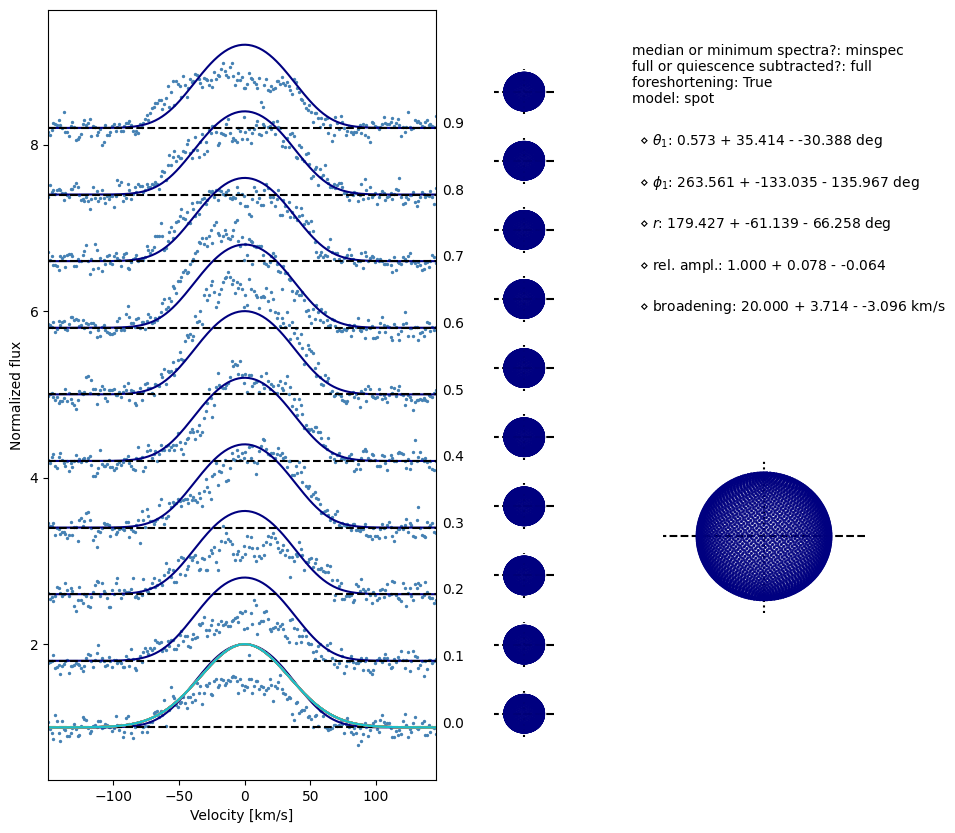

In [ ]:
off=0
fig, ax1 = plt.subplots(1,1,figsize=(5,10))
midphase = alphas_0[::3]
for i, y in enumerate(ys):
    ax1.scatter(vmids, y+off, s=2, c="steelblue")
    ax1.plot(vmids, m[i]+off, c="navy", alpha=1)
    ax1.axhline(1+off, c="k", ls="--")
    ax1.text(vmids[-1]+5, 1+off, f"{midphase[i]/np.pi/2:.1f}")

    # plot gaussian
    # ax1.plot(vmids, 1+np.exp(-vmids**2/48**2))

    # add little image
    # add ax from above to this figure bottom right
    axi = fig.add_axes([1., (off*.864+1)/10, 0.15, 0.15], projection='3d')
    auroral_obj.plot_sphere_only(axi, sphere_alpha=0.00198, c="peru", s=0.1)
    if spotring == "spot":
        auroral_obj.plot_spot(axi,alpha=alphas_0[i*3], s=0.05)
    elif spotring == "ring":
        auroral_obj.plot_ring(axi, alpha=alphas_0[i*3], s=0.05)
    auroral_obj.plot_layout_sphere(axi, view='observer left')
    axi.plot([0, 0], [0, 0], [-1.2, 1.2], c="k", ls=":");


    off += 0.8
ax1.set_xlim(vmids[0], vmids[-1])
ax1.set_xlabel("Velocity [km/s]")
ax1.set_ylabel("Normalized flux")
ax1.text(vmids[-1] +150, 0.5+off, description)
# add another text with the model parameter and errup and errlo
for i, nam in enumerate(data["paramnames"]):
    errlo_, errup_ = med[i]-errlo[i], errup[i]-med[i]
    name, func, unit = namemap[nam]
    med_, errlo_, errup_ = func(med[i]), func(errlo_), func(errup_) 
    ax1.text(vmids[-1] +155, off-i*0.5, f"$\diamond$ {name}: {med_:.3f} + {errup_:.3f} - {errlo_:.3f} {unit}")





# add ax from above to this figure bottom right
ax = fig.add_axes([1.3, 0.1, 0.5, 0.5], projection='3d')
auroral_obj.plot_sphere_only(ax, sphere_alpha=0.01)
if spotring == "spot":
    auroral_obj.plot_spot(ax,alpha=alphas_0[-1])
elif spotring == "ring":
    auroral_obj.plot_ring(ax, alpha=alphas_0[-1], s=0.05)
auroral_obj.plot_layout_sphere(ax, view='observer left')
ax.plot([0, 0], [0, 0], [-1.2, 1.2], c="k", ls=":");


# plt.savefig(f"results/diagnostics_{spec}_{full_sub}_{spotring}_{foreshortening}.pdf", dpi=300, bbox_inches='tight')